In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pprint
import cv2
import shutil
import os

In [2]:
train_json = '../Annotations/train.json'
train_data = '../data/train/'

Estructura basica de les dades

In [3]:
with open(train_json, encoding='UTF-8') as json_file:
    data = json.load(json_file)
    pprint.pprint(data[0])

{'answer_type': 'other',
 'answerable': 1,
 'answers': [{'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil', 'answer_confidence': 'yes'},
             {'answer': 'basil', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil leaves', 'answer_confidence': 'yes'},
             {'answer': 'basil', 'answer_confidence': 'yes'}],
 'image': 'VizWiz_train_00000000.jpg',
 'question': "What's the name of this product?"}


Percentatge d'imatges que no es poden respondre

In [4]:
answerability = [d["answerable"] for d in data]
non_answerable = len(data) - sum(answerability)
non_answble_imgs_percent = (non_answerable / len(data)) * 100
non_answble_imgs_labels = [d["image"] for d in data if d["answerable"] == 0]

print(f"Non-answerable: {non_answerable} imgs = {round(non_answble_imgs_percent, 2)}%")

Non-answerable: 5532 imgs = 26.96%


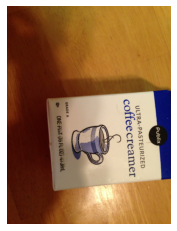

In [5]:
img = cv2.imread(train_data + non_answble_imgs_labels[20])
imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(imgc)
plt.axis('off')
plt.show()

Copiar les imatges NAI (Non-Answerable-Images) en una carpeta a aprt

In [6]:
source = '../data/train/'
destination = '../data/NAI_train/'

In [7]:
# Creating storing folders
if not (os.path.isdir(destination)):
    os.mkdir(destination)

In [8]:
if len(os.listdir(destination)) == 0:
    for fs in non_answble_imgs_labels:
        full_file = source + "\\" + fs
        shutil.copy(full_file, destination + "\\" + fs)
    print("Files moved succesfully!")